# Web Scraping & Sentiment Analysis of NUSMods Module Reviews

## Background, Motivations & Initial Scripts

### Context

This notebook serves to document my results and learnings from my first personal project for data analytics. As I do not have a portfolio website at the time of writing, I have decided to document my process on a Jupyter notebook where it is easy to present code, diagrams and text. The analysis does have some limitations which will be mentioned at the end, with much potential for improvements. This is **not** meant to be a formal report, as it includes some of my personal experiences, and is admittedly wordy.

The motivation for this was actually rooted in frustration - as an avid and competitive video gamer, I was playing some VALORANT and found myself at the mercy of an over-tuned character named Neon, with game mechanics I found to be wildly broken and unfair. I browsed the VALORANT competitive subreddit to find comfort in others who shared the same frustrations as me, refusing to acknowledge my lack of skill. "The game is bad, not me", I figured. Sure enough, at a glance, there was a general consensus that the character was overpowered and not suitable for competitive play in its current state. However, there were some who argued otherwise, that this was a breath of fresh air for the game.

I wondered if I could tangibly quantify which opinion is more popular, or get an overall sentiment towards this character. This was how I went down the rabbit hole of web scraping, as well as sentiment analysis for chunks of text using NLPs. On top of my passion to prove to myself that I'm not bad at a video game, I felt that these skills were highly relevant to my degree and would be helpful to explore.

### First Attempts

Initially, I had tried to apply my newly learnt skills on an E-commerce site, and was quickly stumped by its information hiding and rate-limiting, on top of my inexperience. I decided to switch targets, and managed to scrape a Reddit post's data and its replies, on the VALORANT subreddit. This was done through a short Python script with the praw package. I confirmed my bias that Neon was broken, and used the DistilBERT model on Huggingface for sentiment analysis. Link for model information: https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english

In [6]:
import praw
from transformers import pipeline
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

In [ ]:
reddit = praw.Reddit(user_agent = 'python-auto (by u/Glad-Definition6325)', 
                     client_id = 'LzssjfVOXi18M4lMDTlYiA',
                     client_secret = 'NaeGwCfU6h3cCOrCe4PrguXPQsr-yw',
                     username = 'Glad-Definition6325',
                     password = 'thisisnotactuallythepassword') # Dummy account

url = 'https://www.reddit.com/r/ValorantCompetitive/comments/1gb3x7r/th_riens_im_not_tenz_and_riot_is_not_going_to/'

# Text processing
post = reddit.submission(url=url)
print(post.title)
print(post.selftext)
comment_list = []
for comment in post.comments:
    if comment.body[0] != '>':
        comment_list.append(comment.body)

In [ ]:
# Sentiment Analysis Prep
tokenizer = DistilBertTokenizer.from_pretrained('distilbert/distilbert-base-uncased-finetuned-sst-2-english')
model = DistilBertForSequenceClassification.from_pretrained('distilbert/distilbert-base-uncased-finetuned-sst-2-english')
nlp = pipeline('sentiment-analysis', model = model, tokenizer = tokenizer)
texts = comment_list
results = nlp(texts)

In [ ]:
total_pos, total_neg = 0, 0
for text, result in zip(texts, results):
    print('Comment:', text)
    print('Sentiment:', result)
    if result['label'] == 'POSITIVE': 
        total_pos += 1
    else:
        total_neg += 1
    print("\n")
print(f'Total positive comments: {total_pos}\nTotal negative comments: {total_neg}')

Unfortunately, Reddit does not support endpoints for posts matching a search query, so scraping all posts related to "Neon" would be quite a challenge, given the gargantuan number of posts on such a popular subreddit (sorting by date is unfeasible).

Finally, I turned to NUSMods to test my skills, in hopes of applying them at a larger scale. My project was to scrape the reviews of every module and collate an aggregated sentiment score for all of them. The API documentation explicitly states it does not rate-limit requests, and I was interested in elucidating the behaviour the student population, given the eccentric behaviour seen in the unofficial confessions Telegram channel. My hope was to glean some insights from the reviews left by passionate students.

## Data Processing

It was inconvenient to obtain the reviews from each module's page since the comments are not provided directly by the NUSMods API, and trying to use the Disqus API (what the threads are based on) was more complicated. I used Selenium and a Firefox driver running in headless mode in Python to scrape the HTML for the review content. The key parsing step that eluded me for quite some time was to use one of the driver's methods to switch to the iframe once encountered, else the post thread cannot be seen.

There were 6962 module codes in total provided by the NUSMods API. Since Selenium runs on the CPU, my system took over 4 hours to process all of the modules' reviews, and perform sentiment analysis on them. Of these modules, 40 of them initially turned an error (parse failure rate of 0.575%). Some of these were due to emojis (for which my script could not process their unicode properly), running out of memory mid-run, being unable to find page elements, or the Firefox driver timeout every 30 minutes.

For memory and timeout issues, they were resolved by doing a second run on them. Modules that my script initially failed to locate page elements for were because those modules are not currently available on the NUSMods module list, and are instead in an archive in a separate URL. I had to manually check for their offerings in the AY23/24 archive and run the script on that URL instead. Some other modules don't exist in the archive either, which I suspect are very old modules. Finally, 7 of the engineering module errors were due to emojis in the posts. I could not find an easy way to resolve them, so I decided to omit all 7 of them, though I do not believe this affected the dataset or results very much at all.

The final dataset consists of **6950** modules. 

Of the 12 removed modules:
- Do not Exist: PL4800T, PL4800THM, YSC3260, YSC3332, YSC3334
- Omitted: MLE2102, MLE2103A, MLE2105, MLE3101A, MLE3102, MLE4210, MLE5229

## Sentiment Analysis

Similarly, the model used is the DistilBERT model from Huggingface. Link for model information: https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english

The model assigns either a positive or negative sentiment tag to a chunk of text, along with a score, which is a probability that the text belongs to that tag. We can view it as the strength of the sentiment. 

The aggregate sentiment score was calculated via taking the weighted average of the scores, deducting negative scores from the sum before averaging. The resultant metric is a value from -1 to 1 representing the polarity of the sentiment for that module. The direction corresponds to the sentiment type (negative for negative, positive for positive) while the magnitude represents its strength. 

There is also a PSR (Positive Sentiment Ratio), for a quick, overall gauge of the level of satisfaction for the module. A higher value indicates satisfaction, while a lower value indicates dissatisfaction.

## Code

In [ ]:
from selenium.webdriver.firefox.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.firefox.firefox_profile import FirefoxProfile
from selenium import webdriver
import re
from transformers import pipeline
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
import requests
import csv

# Fetching module list
url = "https://api.nusmods.com/v2/2023-2024/moduleList.json" # Change the AY if necessary
response = requests.get(url)
response.raise_for_status() 
modules = response.json()
module_codes = [module["moduleCode"] for module in modules]

# Firefox Driver setup 
options = Options()
options.add_argument("-headless")
firefox_profile = FirefoxProfile()
firefox_profile.set_preference("javascript.enabled", True)
options.profile = firefox_profile
driver = webdriver.Firefox(options=options)

# Sentiment Analysis Setup - Change or add models to your preference
tokenizer = DistilBertTokenizer.from_pretrained('distilbert/distilbert-base-uncased-finetuned-sst-2-english')
model = DistilBertForSequenceClassification.from_pretrained('distilbert/distilbert-base-uncased-finetuned-sst-2-english')
nlp = pipeline('sentiment-analysis', model = model, tokenizer = tokenizer)  

# Data collection preparation
data = {
    "Module Code": [],
    "Positive Comments": [],
    "Negative Comments": [],
    "Positive Sentiment Ratio": [],
    "Aggregated Sentiment Score": []
}

# Retrieving Disqus comments
for module_code in module_codes:
    try:
        driver.get("https://nusmods.com/courses/CM3141")
        WebDriverWait(driver, 10)
            .until(EC.frame_to_be_available_and_switch_to_it((By.XPATH, "//*[contains(@id,'dsq-app')]"))) # Important
        
        # Check if there are no posts
        st = WebDriverWait(driver, 5)
            .until(EC.presence_of_element_located((By.XPATH, '//*[@id="no-posts"]')))
            .get_attribute('style')
        if "block" in st:
            data["Module Code"].append(module_code)
            data["Positive Comments"].append(None)
            data["Negative Comments"].append(None)
            data["Positive Sentiment Ratio"].append(None)
            data["Aggregated Sentiment Score"].append(None)
            print(f'No reviews for module: {module_code}')
            continue
        else:
            raw_reviews = [my_elem.text for my_elem in WebDriverWait(driver, 15)
                        .until(EC.visibility_of_all_elements_located((By.XPATH, "//ul[starts-with(@class, 'post-list')]")))]

            # Cleaning comments
            reviews = raw_reviews[0].split('Reply')[:-1]
            for i, r in enumerate(reviews):
                nr = r.strip()
                nr = re.sub(r'\s*see more\s*', '', nr)[2:-4]
                if not nr.startswith('NUSMods Mod'):
                    nr = nr[2:]
                reviews[i] = nr
            
            # Processing sentiment - Change or add parameters if needed
            results = nlp(reviews, truncation = True, max_length = 512) # Token limit is 512 for this model

            num_pos, num_neg, sum_score = 0, 0, 0
            for text, result in zip(reviews, results):
                if result['label'] == 'POSITIVE': 
                    num_pos += 1
                    sum_score += result['score']
                else:
                    num_neg += 1
                    sum_score -= result['score']

            pos_ratio = num_pos / (num_pos + num_neg)       
            agg_score = sum_score / (num_pos + num_neg)
            
            data["Module Code"].append(module_code)
            data["Positive Comments"].append(num_pos)
            data["Negative Comments"].append(num_neg)
            data["Positive Sentiment Ratio"].append(pos_ratio)
            data["Aggregated Sentiment Score"].append(agg_score)
            print(f'Finished processing: {module_code}')
    except Exception as e:
        print(f'Error occurred while processing module {module_code}: {e}')
driver.quit()

# Export data as csv
output_file = 'nus_module_sentiments.csv'
with open(output_file, mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerow(data.keys())
    writer.writerows(zip(*data.values()))

## Data Analysis

### Which modules have more reviews?

To start, I kept only the modules that had more than or equal to 5 reviews. This omits modules that just have few or single positive or negative reviews, in which each review carries a larger relative weight (making a strong sentiment score skew the data for that entire module code prefix and misrepresent actual trends). The threshold of 5 reviews was arbitrarily chosen, and is 10% of the maximal review count in the dataset. Modules with 5 or more reviews also already account for the top 4.23% of most highly-reviewed modules in the dataset. 

I also added a column tracking the total number of reviews per module, which is just a summation of the positive and negative reviews.

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('nus_module_sentiments - Copy.csv')
data['Total Reviews'] = data['Positive Comments'] + data['Negative Comments']

reviewed_modules = data[data['Total Reviews'] >= 5].copy()
reviewed_modules['Total Reviews'] = reviewed_modules['Total Reviews'].astype(int)
reviewed_modules['Negative Comments'] = reviewed_modules['Total Reviews'].astype(int)
reviewed_modules['Positive Comments'] = reviewed_modules['Total Reviews'].astype(int)

print((len(reviewed_modules) / 6950) * 100)

4.23021582733813


Firstly, I wanted to investigate if certain faculties' students had a higher propensity to leave reviews. I grouped the module codes' prefixes and summed up the review counts. Modules with the same prefix code are offered by the same faculty and are highly related to each other.

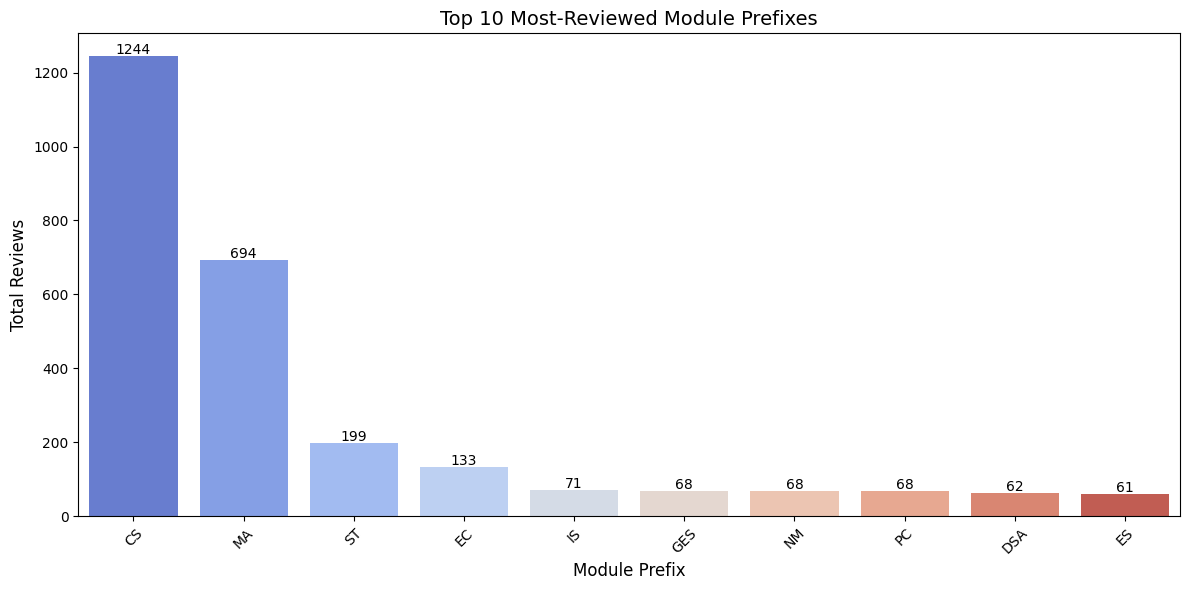


Top 10 reviewed modules:
      Module Code  Positive Comments  Negative Comments  \
1154     CS1101S                 50                 50   
3932      MA1521                 50                 50   
1162      CS2100                 50                 50   
1169      CS2105                 49                 49   
1156     CS1231S                 49                 49   
1152     CS1010S                 49                 49   
1155      CS1231                 46                 46   
1187      CS3230                 45                 45   
6071      ST2132                 42                 42   
3938      MA2104                 42                 42   

      Positive Sentiment Ratio  Aggregated Sentiment Score  Total Reviews  \
1154                  0.480000                   -0.036659             50   
3932                  0.180000                   -0.646729             50   
1162                  0.240000                   -0.511000             50   
1169                  0.38

In [5]:
reviewed_modules['Module Prefix'] = reviewed_modules['Module Code'].str.extract(r'^([A-Za-z]+)')

prefix_reviews = reviewed_modules.groupby('Module Prefix')['Total Reviews'].sum().sort_values(ascending=False)
top_reviewed = reviewed_modules.sort_values('Total Reviews', ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=prefix_reviews.index[:10], y=prefix_reviews.values[:10], palette='coolwarm')

for i, value in enumerate(prefix_reviews.values[:10]):
    plt.text(i, value + 5, str(value), ha='center', fontsize=10)

plt.title('Top 10 Most-Reviewed Module Prefixes', fontsize=14)
plt.xlabel('Module Prefix', fontsize=12)
plt.ylabel('Total Reviews', fontsize=12)

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

print("\nTop 10 reviewed modules:\n", top_reviewed)

From the output, we see a general pattern that STEM modules tend to have the most reviews. The top 5 prefix groups correspond to Computer Science, Mathematics, Statistics, Economics and Information Systems. Of these five, Economics was the only humanities-coded module, itself being slightly math-inclined, and also a highly popular subject of study among the humanities. IS-coded modules from the School of Computing are mostly what students would call "fluff" modules, covering mostly non-rigourous subjects like AI ethics, data privacy or presentation skills.

Of the top 10 most-reviewed individual modules, 7 were CS-coded, 2 were MA-coded, and 1 was ST-coded.

This set of modules being more highly-reviewed suggests that School of Computing students have a greater behavioural tendency to post their module reviews for others to view. Perhaps these modules, having a reputation for being more academically demanding in general, make student dissatisfaction more likely (due to stress, workload, difficulty of content), for which they air their grievances online. Conversely, there could be more good Samaritans who want to share their learning experiences so that students enrolling in the future can navigate these modules more easily.

Next, I wanted to investigate if instead of the module code prefix, the level of the module (1k, 2k, 3k etc.) would also affect the number of module reviews. My hypothesis was that a lower module level would have higher review counts, since these are typically common modules taken by students from multiple majors and have higher enrolment, increasing the likelihood of reviews.

In [6]:
reviewed_modules['Level Bin'] = data['Module Code'].str.extract(r'(\d)').astype(int) * 1000
bin_frequencies = reviewed_modules['Level Bin'].value_counts().sort_index()

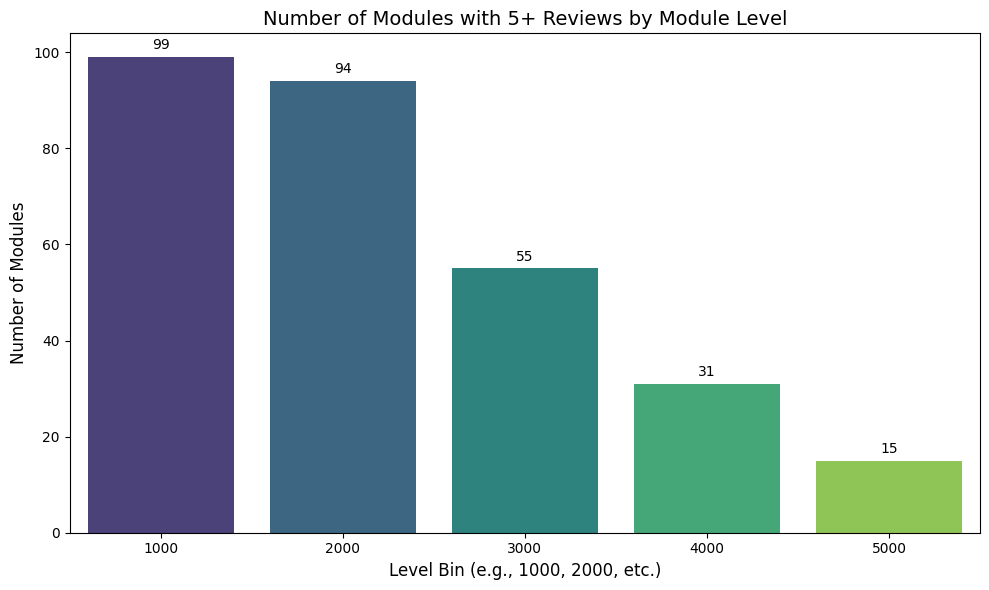

In [7]:
plt.figure(figsize=(10, 6))
sns.barplot(x=bin_frequencies.index, y=bin_frequencies.values, palette='viridis')

for i, value in enumerate(bin_frequencies.values):
    plt.text(i, value + 1, str(value), ha='center', va='bottom', fontsize=10)

plt.title('Number of Modules with 5+ Reviews by Module Level', fontsize=14)
plt.xlabel('Level Bin (e.g., 1000, 2000, etc.)', fontsize=12)
plt.ylabel('Number of Modules', fontsize=12)
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

Overall, the level of a module is inversely related to their review frequencies. 1k and 2k level mods have similar amounts of student reviews, with a steadily decreasing trend from the 2k level upwards.

### Which modules do students like more? (Or do they dislike all of them?)

Let us get a sensing of the overall sentiment of reviews across NUSMods from the data.

In [8]:
mean_sentiment = data['Aggregated Sentiment Score'].mean()
prefix_sentiment = reviewed_modules.groupby('Module Prefix')['Aggregated Sentiment Score'].mean()
prefix_rev = reviewed_modules.groupby('Module Prefix')['Total Reviews'].sum()
prefix_analysis = pd.DataFrame({
    'Average Sentiment Score': prefix_sentiment,
    'Total Reviews': prefix_rev
}).sort_values('Average Sentiment Score')

print(f"Average Sentiment Score: {mean_sentiment}")
print("\nAverage Sentiment Score by Prefix, with Total Review Count:\n", prefix_analysis)

Average Sentiment Score: -0.25910014628271405

Average Sentiment Score by Prefix, with Total Review Count:
                Average Sentiment Score  Total Reviews
Module Prefix                                        
GESS                         -0.978215              6
LAM                          -0.960455              5
SPH                          -0.956989              5
LAK                          -0.878402             15
DAO                          -0.815696             11
...                                ...            ...
SW                            0.363207              7
GEH                           0.422841             16
MT                            0.740685              9
SN                            0.743013             13
BSN                           0.980897              9

[70 rows x 2 columns]


The mean sentiment across all reviews is -0.26, which is slightly negative overall. A possible explanation is that students have greater inclinations to post reviews on NUSMods when they have negative experiences, to vent any frustrations or warn other students before they plan to take these modules. This causes more negative comments than positive comments in the dataset.

The GESS module code corresponds to Singapore Studies modules under the school's compulsory General Education pillar. It was reviewed the most negatively, though it only has 6 reviews in total. Does that make these modules bad? That's up to the reader to decide if 6 very strongly negative reviews is sufficient, or are just statistical coincidences. Personally, I would give the benefit of the doubt. What is less defendable are the LAK and DAO-coded modules, which are the Korean language modules and modules from the Department of Analytics and Operations respectively. 15 and 11 reviews is a respectable number of total reviews in this dataset and is not insignificant, suggesting that the negative sentiment may be commonly shared among students enrolled in these modules. Not having taken any of these modules, I cannot postulate any deeper reasoning for this. Take it for what you will.

On the other hand, modules with the top 5 most positive sentiment scores have more total reviews in general than the top 5 most negative sentiment scores, which makes them slightly more convincing. Notably, GEH and SN-coded modules are in this list, which both teach a wide variety of modules covering historical and cultural studies e.g. South Asian Studies, Japanese Studies, Chinese Studies, Theatre Studies, which contrasts the poor reception of the GESS-coded modules. It is ironic that students seem to be more satisfied with the teachings of other cultures than that of our own.

Next, I wanted to see if there was any relationship between the number of reviews of a module, and its sentiment. Would a higher number of reviews indicate more complaints?

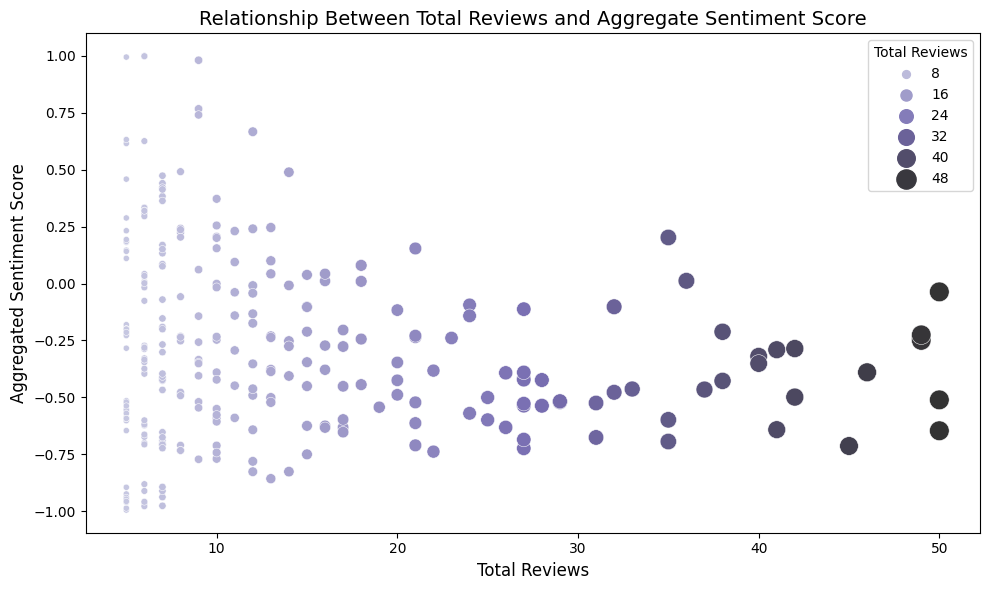

In [13]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=reviewed_modules['Total Reviews'], 
    y=reviewed_modules['Aggregated Sentiment Score'], 
    hue=reviewed_modules['Total Reviews'], 
    palette='Purples_d', 
    size=reviewed_modules['Total Reviews'],
    sizes=(20, 200)
)

plt.title('Relationship Between Total Reviews and Aggregate Sentiment Score', fontsize=14)
plt.xlabel('Total Reviews', fontsize=12)
plt.ylabel('Aggregated Sentiment Score', fontsize=12)

plt.legend(title='Total Reviews', loc='upper right')
plt.tight_layout()
plt.show()

From this scatterplot, there is no clear relationship between the total number of reviews and aggregate sentiment score. What we do see is the expected behaviour that the variance of aggregate sentiment scores gets tighter as the number of total reviews increases, and they all hover around the negative sentiment range.

### Is there a relationship between module workload and its sentiment?

Module workload, while provided by the NUSMods API, was excluded from my original data scraping. This is because the documentation states that the workload values taken from NUS official sources are not always in a consistent format (arrays with a mix of integers and strings, or special characters, or no array at all). Furthermore, while workload is supposed to represent the hours of work per week expected for this module, some sources list their workloads as **total** hours in the module, across the semester. With no way to discern which modules would have erroneous workload hours, I could not trust the data.

However, I have decided to scrape and include them now because I believe that the workload hours should be updated and correct for most popular, relevant and new modules, while the erroneous workload hours would largely come from niche or old modules. From a visual inspection, it does seem that the majority of these problematic modules have no reviews either way (and a lot of them are high-level coded modules), so I have decided to include the workload values in the dataset with the belief that the majority of them would be correct anyway, and I can glean some insight.

In total, there were **251** modules' workload values I had to omit as I was unable to obtain their workload via the intended JSON parsing.

I then did a left join of the workload data on the current data based on module code.

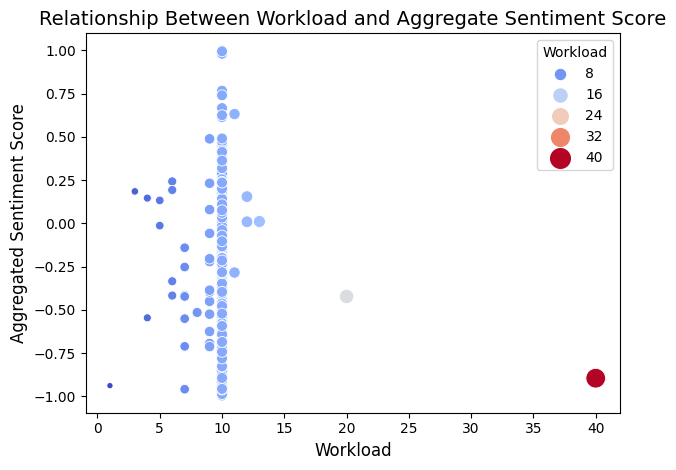

In [14]:
workload_data = pd.read_csv('nus_module_workloads.csv')
merged_data = reviewed_modules.merge(workload_data, on='Module Code', how='left')

sns.scatterplot(
    x=merged_data['Workload'], 
    y=merged_data['Aggregated Sentiment Score'], 
    hue=merged_data['Workload'], 
    palette='coolwarm', 
    size=merged_data['Workload'],
    sizes=(20, 200)
)

plt.title('Relationship Between Workload and Aggregate Sentiment Score', fontsize=14)
plt.xlabel('Workload', fontsize=12)
plt.ylabel('Aggregated Sentiment Score', fontsize=12)

plt.legend(title='Workload', loc='upper right')
plt.tight_layout()
plt.show()

Unfortunately, there is no clear relationship between workload and total reviews. This was when I discovered that NUS modules seem to mostly abide by giving 10 hours of work per week, so there is no insight to gain. Datapoints before the 10 hour workload do not seem to follow any pattern at all either. 

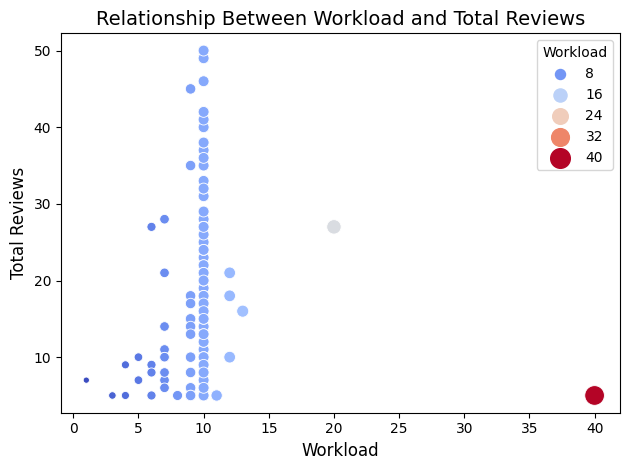

In [15]:
sns.scatterplot(
    x=merged_data['Workload'], 
    y=merged_data['Total Reviews'], 
    hue=merged_data['Workload'], 
    palette='coolwarm', 
    size=merged_data['Workload'],
    sizes=(20, 200)
)

plt.title('Relationship Between Workload and Total Reviews', fontsize=14)
plt.xlabel('Workload', fontsize=12)
plt.ylabel('Total Reviews', fontsize=12)

plt.legend(title='Workload', loc='upper right')
plt.tight_layout()
plt.show()

The same can be said for the relationship between workload and the total number of reviews of a module.

## Limitations

Notice that the maximum number of reviews for a module in the dataset is 50. This is actually a page view limitation, while the actual module page has slightly more. Looking at the three modules that hit this 50 review cap in the dataset, there is a loss of about 10-20% of the total reviews. This requires navigating to the bottom of the thread and clicking the option to view more posts, and will complicate parsing more.

More glaring limitations are that of the NLP model. From manual inspections of several reviews and their scores, DistilBERT seems to have a negative bias towards reviews that otherwise seem completely neutral. It flags reviews that just list the module's assignments, examinations and workload information as negatives (scores < 0).

Additionally, DistilBERT only allows up to 512 tokens, while some reviews contain much more. This misrepresents the sentiment for the post, especially for reviews where the tone of the sentiment is different at the start and at the end, which the model cannot parse. Even though the number of reviews in excess of 512 tokens in length are the minority, their misrepresentation could have made the general sentiment of the dataset slightly negative, when it was instead closer to neutral.

## Possible Improvements

Upon further research, there are certain ways to bypass the 512 token limit via brute force splitting of text into subtexts, then choosing the highest frequency tag among them (then comes issues of resolving ties, or finding alternative approaches to interpretation). There are also other transformers from Huggingface such as Reformer and Longformer, which are a little too much on my plate for me to handle as of now. This did teach me more about these NLP models and their limitations, and shows potential areas of improvement in the future. I could also explore other models that offer neutral tags, even if their accuracy is slightly poorer, just to obtain more diverse classification. 

There are further things I could explore with this dataset which I was not equipped for at the time of this project. For instance, I could take sentiment analysis a step further and try to find correlations between individual sentiment scores of each review, and the students' grade attained if it is available (many students list their final grade achieved). I could even provide suggested modules to take, that have a combination of the highest satisfaction and the lowest workloads, after accounting for outliers.

Overall, this was an interesting, challenging project that opens up many more areas of web scraping and sentiment analysis for me to explore. Hopefully I will get to make a revised edition of this review analysis (with a bigger dataset by then) in the future, and do more similar projects to hone my skills. It's one thing to analyse a dataset, but a whole different level of satisfaction obtaining that dataset oneself. 